# Riemannian Optimization for Inference in MoG models

The Mixture of Gaussians (MoG) model assumes that datapoints $\mathbf{x}_i\in\mathbb{R}^d$ follow a distribution described by the following probability density function:

$p(\mathbf{x}) = \sum_{m=1}^M \pi_m p_\mathcal{N}(\mathbf{x};\mathbf{\mu}_m,\mathbf{\Sigma}_m)$ where $\pi_m$ is the probability that the data point belongs to the $m^\text{th}$ mixture component and $p_\mathcal{N}(\mathbf{x};\mathbf{\mu}_m,\mathbf{\Sigma}_m)$ is the probability density function of a multivariate Gaussian distribution with mean $\mathbf{\mu}_m \in \mathbb{R}^d$ and psd covariance matrix $\mathbf{\Sigma}_m \in \{\mathbf{M}\in\mathbb{R}^{d\times d}: \mathbf{M}\succeq 0\}$.

As an example consider the mixture of three Gaussians with means
$\mathbf{\mu}_1 = \begin{bmatrix} -4 \\ 1 \end{bmatrix}$,
$\mathbf{\mu}_2 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$ and
$\mathbf{\mu}_3 = \begin{bmatrix} 2 \\ -1 \end{bmatrix}$, covariances
$\mathbf{\Sigma}_1 = \begin{bmatrix} 3 & 0 \\ 0 & 1 \end{bmatrix}$,
$\mathbf{\Sigma}_2 = \begin{bmatrix} 1 & 1 \\ 1 & 3 \end{bmatrix}$ and
$\mathbf{\Sigma}_3 = \begin{bmatrix} 0.5 & 0 \\ 0 & 0.5 \end{bmatrix}$
and mixture probability vector $\boldsymbol{\pi}=\left[0.1, 0.6, 0.3\right]^\top$.
Let's generate $N=1000$ samples of that MoG model and scatter plot the samples:

/opt/hostedtoolcache/Python/3.7.15/x64/lib/python3.7/site-packages/traitlets/traitlets.py:3442: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  FutureWarning,


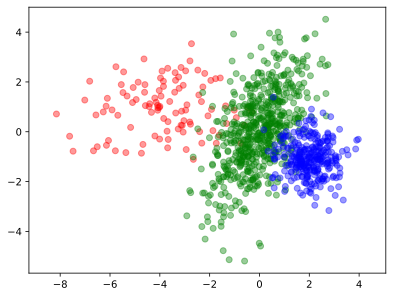

In [1]:
import autograd.numpy as np


np.set_printoptions(precision=2)
import matplotlib.pyplot as plt


%matplotlib inline

# Number of data points
N = 1000

# Dimension of each data point
D = 2

# Number of clusters
K = 3

pi = [0.1, 0.6, 0.3]
mu = [np.array([-4, 1]), np.array([0, 0]), np.array([2, -1])]
Sigma = [
    np.array([[3, 0], [0, 1]]),
    np.array([[1, 1.0], [1, 3]]),
    0.5 * np.eye(2),
]

components = np.random.choice(K, size=N, p=pi)
samples = np.zeros((N, D))
# For each component, generate all needed samples
for k in range(K):
    # indices of current component in X
    indices = k == components
    # number of those occurrences
    n_k = indices.sum()
    if n_k > 0:
        samples[indices, :] = np.random.multivariate_normal(
            mu[k], Sigma[k], n_k
        )

colors = ["r", "g", "b", "c", "m"]
for k in range(K):
    indices = k == components
    plt.scatter(
        samples[indices, 0],
        samples[indices, 1],
        alpha=0.4,
        color=colors[k % K],
    )
plt.axis("equal")
plt.show()

Given a data sample the de facto standard method to infer the parameters is the [expectation maximisation](https://en.wikipedia.org/wiki/Expectation-maximization_algorithm) (EM) algorithm that, in alternating so-called E and M steps, maximises the log-likelihood of the data.
In [arXiv:1506.07677](http://arxiv.org/pdf/1506.07677v1.pdf) Hosseini and Sra propose Riemannian optimisation as a powerful counterpart to EM. Importantly, they introduce a reparameterisation that leaves local optima of the log-likelihood unchanged while resulting in a geodesically convex optimisation problem over a product manifold $\prod_{m=1}^M\mathcal{PD}^{(d+1)\times(d+1)}$ of manifolds of $(d+1)\times(d+1)$ symmetric positive definite matrices.
The proposed method is on par with EM and shows less variability in running times.

The reparameterised optimisation problem for augmented data points $\mathbf{y}_i=[\mathbf{x}_i^\top, 1]^\top$ can be stated as follows:

$$\min_{(\mathbf{S}_1, ..., \mathbf{S}_m, \boldsymbol{\nu}) \in \mathcal{D}}
-\sum_{n=1}^N\log\left(
\sum_{m=1}^M \frac{\exp(\nu_m)}{\sum_{k=1}^M\exp(\nu_k)}
q_\mathcal{N}(\mathbf{y}_n;\mathbf{S}_m)
\right)$$

where

* $\mathcal{D} := \left(\prod_{m=1}^M \mathcal{PD}^{(d+1)\times(d+1)}\right)\times\mathbb{R}^{M-1}$ is the search space
* $\mathcal{PD}^{(d+1)\times(d+1)}$ is the manifold of symmetric positive definite
$(d+1)\times(d+1)$ matrices
* $\mathcal{\nu}_m = \log\left(\frac{\alpha_m}{\alpha_M}\right), \ m=1, ..., M-1$ and $\nu_M=0$
* $q_\mathcal{N}(\mathbf{y}_n;\mathbf{S}_m) =
2\pi\exp\left(\frac{1}{2}\right)
|\operatorname{det}(\mathbf{S}_m)|^{-\frac{1}{2}}(2\pi)^{-\frac{d+1}{2}}
\exp\left(-\frac{1}{2}\mathbf{y}_i^\top\mathbf{S}_m^{-1}\mathbf{y}_i\right)$

**Optimisation problems like this can easily be solved using Pymanopt – even without the need to differentiate the cost function manually!**

So let's infer the parameters of our toy example by Riemannian optimisation using Pymanopt:

In [2]:
import sys


sys.path.insert(0, "../..")

from autograd.scipy.special import logsumexp

import pymanopt
from pymanopt import Problem
from pymanopt.manifolds import Euclidean, Product, SymmetricPositiveDefinite
from pymanopt.optimizers import SteepestDescent


# (1) Instantiate the manifold
manifold = Product([SymmetricPositiveDefinite(D + 1, k=K), Euclidean(K - 1)])

# (2) Define cost function
# The parameters must be contained in a list theta.
@pymanopt.function.autograd(manifold)
def cost(S, v):
    # Unpack parameters
    nu = np.append(v, 0)

    logdetS = np.expand_dims(np.linalg.slogdet(S)[1], 1)
    y = np.concatenate([samples.T, np.ones((1, N))], axis=0)

    # Calculate log_q
    y = np.expand_dims(y, 0)

    # 'Probability' of y belonging to each cluster
    log_q = -0.5 * (np.sum(y * np.linalg.solve(S, y), axis=1) + logdetS)

    alpha = np.exp(nu)
    alpha = alpha / np.sum(alpha)
    alpha = np.expand_dims(alpha, 1)

    loglikvec = logsumexp(np.log(alpha) + log_q, axis=0)
    return -np.sum(loglikvec)


problem = Problem(manifold, cost)

# (3) Instantiate a Pymanopt optimizer
optimizer = SteepestDescent(verbosity=1)

# let Pymanopt do the rest
Xopt = optimizer.run(problem).point

Optimizing...


Terminated - min step_size reached after 144 iterations, 0.41 seconds.



Once Pymanopt has finished the optimisation we can obtain the inferred parameters as follows:

In [3]:
mu1hat = Xopt[0][0][0:2, 2:3]
Sigma1hat = Xopt[0][0][:2, :2] - mu1hat @ mu1hat.T
mu2hat = Xopt[0][1][0:2, 2:3]
Sigma2hat = Xopt[0][1][:2, :2] - mu2hat @ mu2hat.T
mu3hat = Xopt[0][2][0:2, 2:3]
Sigma3hat = Xopt[0][2][:2, :2] - mu3hat @ mu3hat.T
pihat = np.exp(np.concatenate([Xopt[1], [0]], axis=0))
pihat = pihat / np.sum(pihat)

And convince ourselves that the inferred parameters are close to the ground truth parameters.

The ground truth parameters $\mathbf{\mu}_1, \mathbf{\Sigma}_1, \mathbf{\mu}_2, \mathbf{\Sigma}_2, \mathbf{\mu}_3, \mathbf{\Sigma}_3, \pi_1, \pi_2, \pi_3$:

In [4]:
print(mu[0])
print(Sigma[0])
print(mu[1])
print(Sigma[1])
print(mu[2])
print(Sigma[2])
print(pi[0])
print(pi[1])
print(pi[2])

[-4  1]
[[3 0]
 [0 1]]
[0 0]
[[1. 1.]
 [1. 3.]]
[ 2 -1]
[[0.5 0. ]
 [0.  0.5]]
0.1
0.6
0.3


And the inferred parameters $\hat{\mathbf{\mu}}_1, \hat{\mathbf{\Sigma}}_1, \hat{\mathbf{\mu}}_2, \hat{\mathbf{\Sigma}}_2, \hat{\mathbf{\mu}}_3, \hat{\mathbf{\Sigma}}_3, \hat{\pi}_1, \hat{\pi}_2, \hat{\pi}_3$:

In [5]:
print(mu1hat)
print(Sigma1hat)
print(mu2hat)
print(Sigma2hat)
print(mu3hat)
print(Sigma3hat)
print(pihat[0])
print(pihat[1])
print(pihat[2])

[[-3.82]
 [ 1.09]]
[[2.96 0.49]
 [0.49 1.12]]
[[ 2.03]
 [-1.07]]
[[ 0.44 -0.01]
 [-0.01  0.51]]
[[-0.03]
 [-0.01]]
[[1.01 0.89]
 [0.89 2.51]]
0.10340873507365973
0.29045579697232304
0.6061354679540172


Et voilà – this was a brief demonstration of how to do inference for MoG models by performing Manifold optimisation using Pymanopt.

## When Things Go Astray

A well-known problem when fitting parameters of a MoG model is that one Gaussian may collapse onto a single data point resulting in singular covariance matrices (cf. e.g. p. 434 in Bishop, C. M. "Pattern Recognition and Machine Learning." 2001). This problem can be avoided by the following heuristic: if a component's covariance matrix is close to being singular we reset its mean and covariance matrix. Using Pymanopt this can be accomplished by using an appropriate line search rule (based on [BackTrackingLineSearcher](https://github.com/pymanopt/pymanopt/blob/master/pymanopt/optimizers/line_search.py)) -- here we demonstrate this approach:

In [6]:
class LineSearchMoG:
    """
    Back-tracking line-search that checks for close to singular matrices.
    """

    def __init__(
        self,
        contraction_factor=0.5,
        optimism=2,
        sufficient_decrease=1e-4,
        max_iterations=25,
        initial_step_size=1,
    ):
        self.contraction_factor = contraction_factor
        self.optimism = optimism
        self.sufficient_decrease = sufficient_decrease
        self.max_iterations = max_iterations
        self.initial_step_size = initial_step_size

        self._oldf0 = None

    def search(self, objective, manifold, x, d, f0, df0):
        """
        Function to perform backtracking line-search.
        Arguments:
            - objective
                objective function to optimise
            - manifold
                manifold to optimise over
            - x
                starting point on the manifold
            - d
                tangent vector at x (descent direction)
            - df0
                directional derivative at x along d
        Returns:
            - step_size
                norm of the vector retracted to reach newx from x
            - newx
                next iterate suggested by the line-search
        """
        # Compute the norm of the search direction
        norm_d = manifold.norm(x, d)

        if self._oldf0 is not None:
            # Pick initial step size based on where we were last time.
            alpha = 2 * (f0 - self._oldf0) / df0
            # Look a little further
            alpha *= self.optimism
        else:
            alpha = self.initial_step_size / norm_d
        alpha = float(alpha)

        # Make the chosen step and compute the cost there.
        newx, newf, reset = self._newxnewf(x, alpha * d, objective, manifold)
        step_count = 1

        # Backtrack while the Armijo criterion is not satisfied
        while (
            newf > f0 + self.sufficient_decrease * alpha * df0
            and step_count <= self.max_iterations
            and not reset
        ):

            # Reduce the step size
            alpha = self.contraction_factor * alpha

            # and look closer down the line
            newx, newf, reset = self._newxnewf(
                x, alpha * d, objective, manifold
            )

            step_count = step_count + 1

        # If we got here without obtaining a decrease, we reject the step.
        if newf > f0 and not reset:
            alpha = 0
            newx = x

        step_size = alpha * norm_d

        self._oldf0 = f0

        return step_size, newx

    def _newxnewf(self, x, d, objective, manifold):
        newx = manifold.retraction(x, d)
        try:
            newf = objective(newx)
        except np.linalg.LinAlgError:
            replace = np.asarray(
                [
                    np.linalg.matrix_rank(newx[0][k, :, :])
                    != newx[0][0, :, :].shape[0]
                    for k in range(newx[0].shape[0])
                ]
            )
            x[0][replace, :, :] = manifold.random_point()[0][replace, :, :]
            return x, objective(x), True
        return newx, newf, False